6/1 notes:   
TODOs for next time:

- debug the functions for measuring distance and finding time in stop
- run them on larger dataset
- create a module with the functions
- add more utilities to the functions

Adi Watzman   
Nov. 2019    
The goal of this notebook is to develop tools to measure trip time end-to-end.   
The specific use-case now is to compare trip durations before and after "Nativ +" initiative and analyze the differences (if any).


The main steps:
1. Pick route ids and dates.  
* Query the "Open Bus" splunk database and retrieve siri real time data for these routes in the chosen dates.  
* Query the "Open Bus" splunk database and retrieve GTFS stops locations for these routes.  
* Estimate the time the bus passed in the second** stop and the time it arrived to the last stop, and report their   difference as the trip approximate duration.  

** We use the second stop because it is easier to estimate when a bus passes a stop than estimate the time a bus started its trip. For the first stop there can be many cases such as - bus is very late and drives towards the first stop at the time it was suppose to depart, which can cause false departure time estimation.


In order to retrieve data from our splunk database, I use the [splunk utils](https://github.com/hasadna/open-bus/tree/master/splunk/SplunkUtills) module

# Imports and setup

In [1]:
import getpass
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

relative_splunk_utils_path = "../splunk/SplunkUtills"
if relative_splunk_utils_path not in sys.path:
    sys.path.append(relative_splunk_utils_path)

from SplunkUtills import splunk_query_builder, read_splunk

## credentials

In [2]:
with open('/Users/awatzman/Documents/OpenBusDocuments/__credentials.json', 'r') as f:
    credentials = json.load(f)
    
HOST = credentials['host']
PORT = credentials['port']
USERNAME = credentials['username']

In [3]:
# avoid saving the password in a file:
PASSWORD = getpass.getpass()

········


# Templates - Splunk query demo - used for query templates

In [4]:
query = '''search index=route_stats earliest=-20d latest=-10d route_id=5189|
        fields agency_id, route_short_name, route_id, date, all_start_time | '''

GTFS_data = read_splunk(query,
          host =  HOST, port = PORT, username = USERNAME, password = PASSWORD)


start..

your query:
 search index=route_stats earliest=-20d latest=-10d route_id=5189|

        fields agency_id, route_short_name, route_id, date, all_start_time |
 

connection succeed

query status: 100.0%   66 scanned   10 matched   10 results

Done!

query succeed

read results succeed

job finished and canceled

finished! number of rows: 10



In [11]:
GTFS_data

,agency_id,route_short_name,route_id,date,all_start_time
0,15,501,5189,2019-10-30,05:00:00;05:15:00;05:45:00;06:05:00;06:23:00;0...
1,15,501,5189,2019-10-29,05:00:00;05:15:00;05:45:00;06:05:00;06:23:00;0...
2,15,501,5189,2019-10-28,05:00:00;05:15:00;05:45:00;06:05:00;06:23:00;0...
3,15,501,5189,2019-10-27,05:00:00;05:15:00;05:45:00;06:05:00;06:23:00;0...
4,15,501,5189,2019-10-26,20:00:00;20:01:00;20:15:00;20:30:00;20:45:00;2...
5,15,501,5189,2019-10-25,05:00:00;05:30:00;05:45:00;06:00:00;06:15:00;0...
6,3,501,5189,2019-10-24,05:15:00;05:30:00;05:45:00;05:55:00;06:03:00;0...
7,3,501,5189,2019-10-23,05:15:00;05:30:00;05:45:00;05:55:00;06:03:00;0...


In [12]:
query_kwargs = {
                'index': 'siri',
                'earliest': '-10d', #=last 10 days
                'latest': '-7d',
                #'agency_id': 3,
                'route_short_name': 501,
                'route_id': 5189,
                'planned_start_time': '22:00:00',
               #'max_columns': 100000,
               'columns': ['timestamp','agency_id','route_id','route_short_name','service_id','planned_start_time',
                        'bus_id','predicted_end_time','time_recorded','lat','lon']
                }

SIRI_data = read_splunk(splunk_query_builder(**query_kwargs),
          host =  HOST, port = PORT, username = USERNAME, password = PASSWORD)


start..

your query:
 search index=siri earliest=-10d latest=-7d route_short_name=501 route_id=5189 planned_start_time=22:00:00 |
 fields timestamp, agency_id, route_id, route_short_name, service_id, planned_start_time, bus_id, predicted_end_time, time_recorded, lat, lon |


connection succeed

query status: 100.0%   1769 scanned   87 matched   87 results

Done!

query succeed

read results succeed

job finished and canceled

finished! number of rows: 87



In [13]:
SIRI_data

,timestamp,agency_id,route_id,route_short_name,service_id,planned_start_time,bus_id,predicted_end_time,time_recorded,lat,lon
0,2019-11-02T22:26:42,15,5189,501,42135488,22:00:00,86343101,22:45:00,22:26:39,32.168880,34.928661
1,2019-11-02T22:25:42,15,5189,501,42135488,22:00:00,86343101,22:44:00,22:25:34,32.168278,34.928368
2,2019-11-02T22:24:42,15,5189,501,42135488,22:00:00,86343101,22:43:00,22:24:20,32.167198,34.927765
3,2019-11-02T22:23:42,15,5189,501,42135488,22:00:00,86343101,22:42:00,22:23:32,32.165466,34.926895
4,2019-11-02T22:22:42,15,5189,501,42135488,22:00:00,86343101,22:45:00,22:22:10,32.164654,34.924950
...,...,...,...,...,...,...,...,...,...,...,...
82,2019-11-02T21:04:42,15,5189,501,42135488,22:00:00,86343101,22:45:00,20:11:31,0.000000,0.000000
83,2019-11-02T21:03:42,15,5189,501,42135488,22:00:00,86343101,22:45:00,20:11:31,0.000000,0.000000
84,2019-11-02T21:02:42,15,5189,501,42135488,22:00:00,86343101,22:45:00,20:11:31,0.000000,0.000000
85,2019-11-02T21:01:42,15,5189,501,42135488,22:00:00,86343101,22:45:00,20:11:31,0.000000,0.000000


# Get Data

## Pick route ids and dates

Use the route_stats and trip_stats [docs](https://open-bus-gtfs-utils.readthedocs.io/en/latest/trip_stats.html) to find relevant data fields.

In [4]:
# human-friendly settings:
route_short_name = '601'
earliest = "10/30/2019:00:00:00"
latest = "10/31/2019:23:59:59"

In [5]:
# find relevant route ids:

get_route_ids_q = '''
search 
    index=route_stats 
    earliest="{earliest}"
    latest="{latest}" 
    route_short_name={route_short_name} |
fields 
    date, 
    agency_id, 
    route_short_name, 
    route_id,
    start_stop_city,
    start_stop_name,
    end_stop_city,
    end_stop_name,
    all_start_time | 
'''.format(earliest=earliest, latest=latest, route_short_name=route_short_name)

route_ids = read_splunk(get_route_ids_q,
                        host=HOST, port=PORT, username=USERNAME, password=PASSWORD)


start..

your query:
 
search 
    index=route_stats 
    earliest="10/30/2019:00:00:00"
    latest="10/31/2019:23:59:59" 
    route_short_name=601 |

fields 
    date, 
    agency_id, 
    route_short_name, 
    route_id,
    start_stop_city,
    start_stop_name,
    end_stop_city,
    end_stop_name,
    all_start_time |
 


connection succeed

query status: 100.0%   102 scanned   6 matched   6 results

Done!

query succeed

read results succeed

job finished and canceled

finished! number of rows: 6



In [6]:
route_ids

,date,agency_id,route_short_name,route_id,start_stop_city,start_stop_name,end_stop_city,end_stop_name,all_start_time
0,2019-10-31,15,601,18077,תל אביב יפו,ת.מרכזית ת''א ק.6/רציפים,נתניה,ת. רכבת נתניה,19:35:00;20:05:00;20:40:00;21:20:00;21:35:00;2...
1,2019-10-31,15,601,700,תל אביב יפו,ת.מרכזית ת''א ק.6/רציפים,נתניה,ת. רכבת נתניה,05:40:00;06:00:00;06:15:00;06:30:00;06:40:00;0...
2,2019-10-31,15,601,698,נתניה,ת. רכבת נתניה,תל אביב יפו,ת. מרכזית ת''א ק. 6/הורדה,05:30:00;06:00:00;06:20:00;06:40:00;06:50:00;0...
3,2019-10-30,15,601,18077,תל אביב יפו,ת.מרכזית ת''א ק.6/רציפים,נתניה,ת. רכבת נתניה,19:35:00;20:05:00;20:40:00;21:20:00;21:35:00;2...
4,2019-10-30,15,601,700,תל אביב יפו,ת.מרכזית ת''א ק.6/רציפים,נתניה,ת. רכבת נתניה,05:40:00;06:00:00;06:15:00;06:30:00;06:40:00;0...
5,2019-10-30,15,601,698,נתניה,ת. רכבת נתניה,תל אביב יפו,ת. מרכזית ת''א ק. 6/הורדה,05:30:00;06:00:00;06:20:00;06:40:00;06:50:00;0...


In [17]:
#route_ids.all_start_time.str.split(';').apply(lambda x: sorted(x)).values

array([list(['19:35:00', '20:05:00', '20:40:00', '21:20:00', '21:35:00', '21:50:00', '22:10:00', '22:30:00', '22:50:00', '23:10:00', '23:35:00']),
       list(['05:40:00', '06:00:00', '06:15:00', '06:30:00', '06:40:00', '06:50:00', '07:00:00', '07:10:00', '07:20:00', '07:40:00', '07:50:00', '08:00:00', '08:12:00', '08:24:00', '08:36:00', '08:50:00', '09:00:00', '09:10:00', '09:20:00', '09:30:00', '09:45:00', '10:00:00', '10:20:00', '10:40:00', '11:00:00', '11:20:00', '11:40:00', '12:00:00', '12:35:00', '13:00:00', '13:30:00', '14:00:00', '14:30:00', '14:45:00', '15:00:00', '15:20:00', '15:40:00', '16:00:00', '16:20:00', '16:40:00', '17:00:00', '17:25:00', '17:45:00', '18:00:00', '18:25:00', '18:45:00', '19:00:00']),
       list(['05:30:00', '06:00:00', '06:20:00', '06:40:00', '06:50:00', '07:00:00', '07:10:00', '07:20:00', '07:30:00', '07:40:00', '07:50:00', '08:00:00', '08:20:00', '08:40:00', '09:00:00', '09:15:00', '09:30:00', '09:45:00', '10:05:00', '10:25:00', '10:45:00', '11:05:00

Choose the relevat route id and continue:

In [7]:
route_id = '698' # Netanya -> TLV

## Retreive SIRI data

In [8]:
siri_cols = ['timestamp','agency_id','route_id','route_short_name','service_id','planned_start_time',
             'planned_start_date', 'bus_id','predicted_end_time','time_recorded', 'date_recorded', 'lat', 'lon']
query_kwargs = {
                'index': 'siri',
                'earliest': earliest, 
                'latest': latest,
                'route_id': route_id,
                'columns': siri_cols
                }

siri_data = read_splunk(splunk_query_builder(**query_kwargs),
                        host=HOST, port=PORT, username=USERNAME, password=PASSWORD)

start..

your query:
 search index=siri earliest=10/30/2019:00:00:00 latest=10/31/2019:23:59:59 route_id=698 |
 fields timestamp, agency_id, route_id, route_short_name, service_id, planned_start_time, planned_start_date, bus_id, predicted_end_time, time_recorded, date_recorded, lat, lon |


connection succeed

query status: 100.0%   12844 scanned   11530 matched   11530 results

Done!

query succeed

read results succeed

job finished and canceled

finished! number of rows: 11530



In [47]:
siri_data['planned_start_datetime'] = pd.to_datetime(siri_data.planned_start_date + 'T' + siri_data.planned_start_time)
siri_data['datetime_recorded'] = pd.to_datetime(siri_data.date_recorded + 'T' + siri_data.time_recorded)


## Retreive stops locations (GTFS)

Get the all_stop_latlon from route_stats of the relevant route!.   
https://open-bus-gtfs-utils.readthedocs.io/en/latest/index.html

In [10]:
stops_cols = ['route_id', 'date', 'all_stop_id', 'all_stop_code',  'all_stop_latlon']
stops_query_kwargs = {
                      'index': 'route_stats',
                      'earliest': earliest, 
                      'latest': latest,
                      'route_id': route_id,
                      'columns': stops_cols
                      }

stops_data = read_splunk(splunk_query_builder(**stops_query_kwargs),
                         host=HOST, port=PORT, username=USERNAME, password=PASSWORD)

start..

your query:
 search index=route_stats earliest=10/30/2019:00:00:00 latest=10/31/2019:23:59:59 route_id=698 |
 fields route_id, date, all_stop_id, all_stop_code, all_stop_latlon |


connection succeed

query status: 100.0%   24 scanned   2 matched   2 results

Done!

query succeed

read results succeed

job finished and canceled

finished! number of rows: 2



In [11]:
stops_data # one row per route id and date

,route_id,date,all_stop_id,all_stop_code,all_stop_latlon
0,698,2019-10-31,24323;333;358;42546;324;320;309;307;302;291;28...,36875;39247;39273;32196;39237;39233;39222;3922...,"32.319671,34.868105;32.325694,34.864841;32.326..."
1,698,2019-10-30,24323;333;358;42546;324;320;309;307;302;291;28...,36875;39247;39273;32196;39237;39233;39222;3922...,"32.319671,34.868105;32.325694,34.864841;32.326..."


In [12]:
def get_stops_df_per_route_date(row, stops_seq_cols=['all_stop_id', 'all_stop_code', 'all_stop_latlon']):
    """ Create dataframe with a row for each stop
    Input: row - a row of a df generated by the above splunk stops query.
    """
    stops_dict = row.to_dict()
    
    # split each cell with stops sequence:
    for col in stops_seq_cols:
        stops_dict[col] = stops_dict[col].split(';')
    
    # enumerate the stops in the sequence:
    seq_len = len(stops_dict[stops_seq_cols[0]])
    stops_dict['stop_order'] = list(range(seq_len))
    
    return pd.DataFrame(stops_dict)

In [13]:
# reshape the stops_data df to have one row per route_id, date and stop:
stops_data2 = pd.concat([get_stops_df_per_route_date(row) for ind, row in stops_data.iterrows()], axis=0)
stops_data2.columns = [col.replace('all_', '') for col in stops_data2.columns]
stops_data2[['lat', 'lon']] = stops_data2.stop_latlon.str.split(',', expand=True).astype(float)
stops_data2

,route_id,date,stop_id,stop_code,stop_latlon,stop_order,lat,lon
0,698,2019-10-31,24323,36875,"32.319671,34.868105",0,32.319671,34.868105
1,698,2019-10-31,333,39247,"32.325694,34.864841",1,32.325694,34.864841
2,698,2019-10-31,358,39273,"32.326819,34.862473",2,32.326819,34.862473
3,698,2019-10-31,42546,32196,"32.326629,34.857538",3,32.326629,34.857538
4,698,2019-10-31,324,39237,"32.324201,34.856548",4,32.324201,34.856548
...,...,...,...,...,...,...,...,...
42,698,2019-10-30,13103,21472,"32.074914,34.790734",42,32.074914,34.790734
43,698,2019-10-30,13206,21675,"32.07189,34.789291",43,32.071890,34.789291
44,698,2019-10-30,39960,20143,"32.066005,34.786424",44,32.066005,34.786424
45,698,2019-10-30,13277,22947,"32.061357,34.78463",45,32.061357,34.784630


# TODO - Estimate trip time

In [ ]:
# main flow:
# group SIRI by trip. 
# for each trip - identify the closest time to second stop.
# for each trip - identify the first closest time after (?) last stop.


# for this, we need a function that gets a series of one trip + stop location and identifies:
    # the closest GPS to this stop
    # + with largest possible distance constraint
    # + with option to only before or after the stop (this should also get the shape of the the route and identify direction.)
    
    

Continue from here!!!!!!!   
I need to take "ord_trip", which is the ordered group of siri points for one trip, and extract the closest point to the 2nd and last stops. 

In [74]:
i = 0
# group siri by trip:
# 
for ids, grp in siri_data[siri_data.lat > 0] \
                        .groupby(['planned_start_datetime', 'agency_id', 'route_id', 'bus_id'],
                                 sort=True):
    if i == 11: # just for debug, choose arbitrary trip (group of siri entries)
        break
    i += 1
print(ids)
ord_trip = grp.sort_values('time_recorded') # sort
ord_trip = ord_trip.drop_duplicates(subset=['datetime_recorded', 'lat', 'lon'], keep='first') # drop dups

(Timestamp('2019-10-30 08:00:00'), 15, 698, 47085801)


In [75]:
ord_trip.shape

(83, 15)

In [106]:
x, y = nearest_points(MultiPoint(ord_trip[['lat', 'lon']].values), Point((32.325694, 34.864841)))
(x.x, x.y), (y.x, y.y)

((32.327503204345696, 34.86050033569336), (32.325694, 34.864841))

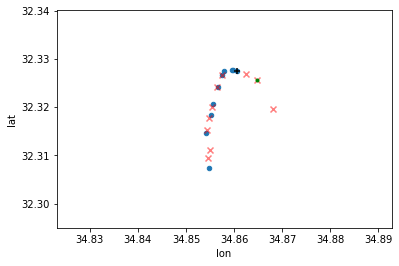

In [110]:
# vizualization for validation
ax = ord_trip.iloc[:10].plot.scatter('lon', 'lat')
ax.scatter(stops_data2.iloc[:10].lon, stops_data2.iloc[:10].lat, color='r', marker='x', alpha=0.5)


# ax.scatter(x.y, x.x, marker='+', color='k')
# ax.scatter(y.y, y.x, marker='.', color='g')




ax.axis('equal')
plt.show()

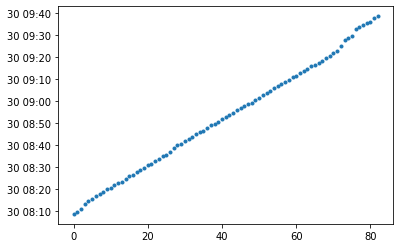

In [78]:
# sanity check - entries by "time recorded"
plt.plot(ord_trip.datetime_recorded.reset_index(drop=True), marker='.', ls='')
plt.show()

In [89]:
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points

In [ ]:
ord_trip.datetime_recorded

In [126]:
# define a function to get: stops_df, ord_trip_df, stop_ind, dt_at_stop_func
# and returns the datetime and exact GPS for being at this stop approximated by the chosen func

def closest_to_point(trip_df, point_lat, point_lon):
    """ Find the time and location of the bus which is closest to the given point
    
    ###TODO - allow limitation of the distance from point
    ###TODO - allow relativeness - closest location before/after point, ...
    ###TODO - how do we deal with circular routes (that pass close to a point several times)
    """
    trip_points = MultiPoint(trip_df[['lat', 'lon']].values)
    point = Point(point_lat, point_lon)
    print("here")
    nrst, _ = nearest_points(trip_points, point)
    
    trip_row = trip_df[(trip_df.lat == nrst.x) & (trip_df.lon == nrst.y)] 
    ## TODO - what happens if we get more than 1 row?
    
    return trip_row.datetime_recorded, (trip_row.lat, trip_row.lon)
    


def detect_bus_at_stops(trip_df, stops_df, stops_inds, time_at_stop_func):
    """ Detect the time a bus was located at the given stops
    
    params:
    trip_df: pandas df, siri data for the relevant trip.
             With columns: ###todo continue, 
             ordered in ascending order by 'datetime_recorded'.
    stops_df: pandas df, GTFS shape for the relevant route.
              With columns: ###todo continue, 
              ordered by 'stop_order'
    stops_inds: Iterable. Indices of the stops at which the bus should be detected 
                (corresponding to stop_order). ##TODO - allow a single index 
    time_at_stop_func: function with input: trip_df, GPS point; 
                       and output: estimated time and location of the bus in this point.
                       ## TODO - allow additional args to be sent to time_at_stop_func
    Return: dict, Estimated time and location of the bus per stop_ind
    """
    res = dict()
    for ind in stops_inds:
#         point_lat, point_lon = 
        print(stops_df[stops_df.stop_order == ind][['lat', 'lon']].astype('float'))
        print(point_lat, point_lon)
        res[ind] = time_at_stop_func(trip_df, point_lat, point_lon) # TODO allow additional args
        
    return res
    
    

In [127]:
# TODO - get last stop ind
detect_bus_at_stops(ord_trip, stops_data2[(stops_data2.route_id == ord_trip.route_id.iloc[0]) & 
                                          (stops_data2.date == ord_trip.date_recorded.iloc[0])], 
                    [1], closest_to_point)

         lat        lon
1  32.325694  34.864841


NameError: name 'point_lat' is not defined

In [102]:
### GPS for a specific stop! TODO - insert to a function and apply to 2nd and last stops.
stop_ind = 1
stop_latlon = stops_data2[(stops_data2.route_id == ord_trip.route_id.iloc[0]) & 
                          (stops_data2.date == ord_trip.date_recorded.iloc[0]) &
                          (stops_data2.stop_order == stop_ind)
                         ].stop_latlon.values[0]
stop_lat, stop_lon = [float(x) for x in stop_latlon.split(',')]
# stop_pnt = Point(float(cur_lon), float(cur_lat))

In [103]:
stop_lat, stop_lon

(32.325694, 34.864841)

In [81]:
stop_lat

32.325694

## appendix - plot GPS

In [72]:
import geopandas
from shapely.geometry import Point

In [91]:
def plot_gps(df):
    """ df with columns 'lat' and 'lon'"""
    data = df[df.lat > 0]
    coord = pd.Series(list(zip(data.lon, data.lat))).rename('Coordinates').apply(Point).to_frame()
    gdata = geopandas.GeoDataFrame(coord, geometry='Coordinates')
    ax = gdata.plot()
    return ax
    

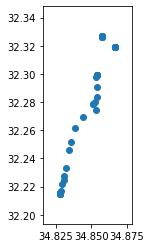

In [94]:
# sanity check - GPS points
ax = plot_gps(ogrp)

plt.show()

## TODO - Pick the 2nd and last stops for each route id and date, estimate the time in these stops using SIRI data, and claculate the time difference.

# TODO - run on larger scale - to get statistics.

## TODO - convert the important code parts to a generic module